## Copy Task

This experimental notebook concerns the _copy_ task as defined by [Collier and Beel (2018)](TODO) based on the original _Neural Turing Machines_ paper of [Graves, Wayne, and Danihelka (2014)](TODO).

In particular, the input time series for this task consist of random 8-bit strings followed by a sequence end token (in this case just all zeros). The length of the sequence is sampled uniformly at random in the interval $[1, 20]$. After the input string has ended, the neural net should produce the input string as output, i.e. copy the input string to the output. As this task requires variable-length memory, standard recurrent nets are assumed to be bad at it.

In [1]:
import random
import numpy as np

# define the input generating function
def generate_seq(max_len, n, force_length = False):
    # start by sampling the sequence length
    if not force_length:
        T = random.randrange(1, max_len+1)
    else:
        T = max_len
    # initialize the input and output sequence
    X = np.zeros((2*T+2, n+1))
    Y = np.zeros((2*T+2, n))
    # fill the input sequence with random bits
    X[1:T+1, :n] = np.round(np.random.rand(T, n))
    # add the end of sequence token
    X[T+1, n]  = 1.
    # and copy the sequence to the output
    Y[T+2:, :] = X[1:T+1, :n]
    # return
    return X, Y

# generate the input data
num_folds = 20
num_seqs_per_fold = 10
n = 8
max_len = 20
Data = []
for f in range(num_folds):
    Xs = []
    Ys = []
    for j in range(num_seqs_per_fold):
        X, Y = generate_seq(max_len, n)
        Xs.append(X)
        Ys.append(Y)
    Data.append((Xs, Ys))

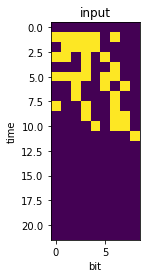

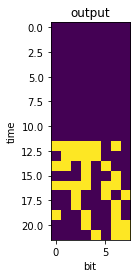

In [3]:
import matplotlib.pyplot as plt
# show an example data point
plt.imshow(X)
plt.title('input')
plt.xlabel('bit')
plt.ylabel('time')
plt.show()
plt.imshow(Y)
plt.title('output')
plt.xlabel('bit')
plt.ylabel('time')
plt.show()

In [4]:
# set the hyper-parameter ranges for all models
models = ['ESN', 'ESGRU', 'RMM']
ms   = [128]
vs   = [0.1, 0.3, 0.5]
w_cs = [0.1, 0.7, 0.9]
w_js = [0.1, 0.2, 0.4]
ls   = [4, 8, 16]
leaks = [1.]
v_gates = [0.2, 0.4, 0.8, 1.6]
bases = [4, 8, 16]
steps_selfs  = [1, 2, 4]
steps_others = [1, 2, 4]
Ks   = [21]
bias_writes = [0.1, 0.2, 0.4]
bias_reads  = [0.1, 0.2, 0.4]
num_reads  = [4, 8, 16]
controller_initializations  = ['identity']
permit_duplicatess  = [True]
reguls = [1E-5]
input_normalizations = [False]
washouts = [0]

R = 10
num_hyperopt_folds = 3

In [6]:
# perform a crossvalidation and compare the results
# of all models
import rmm.hyperopt as hyperopt

errs   = np.zeros((len(models), num_folds))

for f in range(num_folds):
    print('--- fold %d of %d ---' % (f+1, num_folds))
    # accumulate the training data
    Xs = []
    Ys = []
    for f2 in range(num_folds):
        if f == f2:
            continue
        Xs += Data[f2][0]
        Ys += Data[f2][1]
    Xs_test = Data[f][0]
    Ys_test = Data[f][1]
    # iterate over the models
    for m in range(len(models)):
        print('starting hyper-parameter optimization for %s' % models[m])
        # train the model with hyperparameter optimization on a subset
        # of folds
        perm = np.random.permutation(num_folds)
        perm = perm[perm != f]
        train_folds = []
        for f3 in perm[:num_hyperopt_folds]:
            train_folds.append(Data[f3])
        if models[m] == 'ESN':
            model, _, _, _ = hyperopt.hyperopt_esn(train_folds, R, ms, vs, w_cs, w_js, ls, leaks, reguls, input_normalizations, washouts)
        elif models[m] == 'ESGRU':
            model, _, _, _ = hyperopt.hyperopt_esgru(train_folds, R, ms, vs, w_cs, w_js, ls, v_gates, reguls, input_normalizations, washouts)
        elif models[m] == 'RMM':
            model, _, _, _ = hyperopt.hyperopt_rmm(train_folds, R, ms, vs, w_cs, w_js, ls, leaks, Ks, controller_initializations, permit_duplicatess, reguls, input_normalizations, washouts)
        else:
            raise ValueError('Unsupported Model type: %s' % models[m])
        # train the model
        print('fitting %s' % models[m])
        model.fit(Xs, Ys)
        # evaluate the model on the test data
        for j in range(len(Xs_test)):
            Yhat = model.predict(Xs_test[j])
            errs[m, f] += np.sqrt(np.mean(np.square(Ys_test[j] - Yhat)))
        errs[m, f] /= len(Xs_test)
        print('completed %s' % models[m])

/usr/lib64/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


--- fold 1 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 2 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 3 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 4 of 20 ---
starting hyper-parameter optimization for ESN
fitting ESN
completed ESN
starting hyper-parameter optimization for ESGRU
fitting ESGRU
completed ESGRU
starting hyper-parameter optimization for RMM
fitting RMM
completed RMM
--- fold 5 of 20 ---
startin

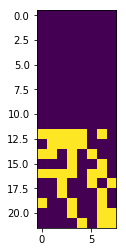

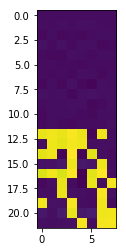

In [7]:
import matplotlib.pyplot as plt
plt.imshow(Ys_test[j])
plt.show()
plt.imshow(Yhat)
plt.show()

In [8]:
for m in range(len(models)):
    print('RMSE for %s: %g +- %g' % (models[m], np.mean(errs[m, :]), np.std(errs[m, :])))

RMSE for ESN: 0.361248 +- 0.023039
RMSE for ESGRU: 0.330573 +- 0.0067255
RMSE for RMM: 0.024791 +- 0.0273552
